League Ranked Game Classifier for North American Diamond Tier Games

Contributors - Susom, Adora, Luke

Problem Description:

<p>
League of Legends (LoL) is a massively multiplayer online game in which two teams of five players compete to destroy the other team's "nexus." Various objectives, gold-securing methods, and combat-oriented situations exist to provide teams advantages over one another, creating paths to victory. These metrics can be tracked to classify and ultimately predict game outcomes before they happen.


<p>
As a competitive game, LoL features a ranked system that allows players to gain rating through game victories. Notably, destroying the opposing nexus isn't the only way to end the game; teams have the choice of forfeiting from 15 minutes after the game starts. Considering the average LoL game lasts about 30 minutes, choosing to forfeit a lost game can increase game volume by saving time and prompt better game outcomes by preserving players' mental fortitude (subsequently increasing rating gain).

<p>
Considering 15 minutes is about half a game's average runtime, a reasonably educated prediction of the game's outcome can be made based on team statistics at this time. This project aims to create a sufficiently effective game classifier that produces outcomes (win/loss) based on statistics at 15 minutes. These decisions can then be used to decide if a player should forfeit their match. Specifically, we want to produce a classifier with a minimum accuracy threshold of 70%. To do this, various classifier methods will be explored and evaluated.  

<p>
Certain challenges exist in creating a good classifier. Various factors impact a game's progression and outcome, and each significant game event can produce a waterfall effect that impacts other game events (either positively or negatively). Naturally, inherent uncertainty exists because teams of humans can make mistakes even from an advantaged state. Considering these numerous factors, creating an accurate classifier is difficult. To solve these issues, points of variation will be minimized. A subset of North American Diamond Tier LoL games will be sampled to narrow the project scope and reduce variation. In principle, this works because players at higher tiers should have learned similar gameplay patterns through experience, be more invested in their game outcomes, and exhibit more consistent play patterns. Beyond this, significant in-game metrics will be chosen through domain knowledge to provide consistent prediction points.

Preliminaries

In [ ]:
# regular imports
import pandas as pd
import numpy as np
import math

# k nearest neighbors imports
from sklearn.neighbors import KNeighborsClassifier # import k nearest neighbors

# decision tree imports
from sklearn.tree import DecisionTreeClassifier # creates decision tree
from sklearn.model_selection import train_test_split # breaks data into training and testing sets
from sklearn import metrics # used for evaluation

# visualization
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

import matplotlib.pyplot as plt

In [ ]:
# evaluation helper function
def evaluate(ground_truth, prediction):
  # create confusion matrix
  confusion_matrix = metrics.confusion_matrix(ground_truth, prediction) # create confusion matrix object
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['loss', 'win']) # convert confusion matrix to be displayed

  # display confusion matrix using matplot
  cm_display.plot()
  plt.show()

  # show accuracy
  print("Accuracy:", metrics.accuracy_score(ground_truth, prediction))

Preprocessing

Clean dataset with no missing values. Only necessary preprocessing is attribute subset selection (dimensional reduction/eliminate redundancy) and integration.

In [ ]:
# dataset link
dataset = "https://raw.githubusercontent.com/SusomHait/COSE471---Project/main/LoL_15_Diamond.csv"

# attribute subset selection (through domain knowledge)
# chose consistent, irredundant variables that contribute to game outcomes
blue_side_attributes = ['blue_Win', 'blue_Wards', 'blue_Wards_Destroyed', 'blue_First_Blood', 'blue_Kills', 'blue_Aces', 'blue_Assists', 'blue_Void_Grubs', 'blue_Cloud_Drake', 'blue_Infernal_Drake', 'blue_Mountain_Drake', 'blue_Ocean_Drake', 'blue_Chemtech_Drake', 'blue_Hextech_Drake', 'blue_Heralds', 'blue_Towers_Destroyed', 'blue_Turret_Plates', 'blue_Inhibitors', 'blue_Total_Gold', 'blue_Avg_Level', 'blue_Total_CS', 'blue_Total_Jungle_Monsters', 'blue_Gold_Diff', 'blue_XP_Diff', 'blue_Total_Dmg']
red_side_attributes = ['red_Win', 'red_Wards', 'red_Wards_Destroyed', 'red_First_Blood', 'red_Kills', 'red_Aces', 'red_Assists', 'red_Void_Grubs', 'red_Cloud_Drake', 'red_Infernal_Drake', 'red_Mountain_Drake', 'red_Ocean_Drake', 'red_Chemtech_Drake', 'red_Hextech_Drake', 'red_Heralds', 'red_Towers_Destroyed', 'red_Turret_Plates', 'red_Inhibitors', 'red_Total_Gold', 'red_Avg_Level', 'red_Total_CS', 'red_Total_Jungle_Monsters', 'red_Gold_Diff', 'red_XP_Diff', 'red_Total_Dmg']

# final attribute list (dependent + independent variables)
# 26 attributes total (down from 89 original)
integrated_attributes = ['Win', 'Wards', 'Wards_Destroyed', 'First_Blood', 'Kills', "Aces", 'Assists', 'Grubs', 'Cloud', 'Infernal', 'Mountain', 'Ocean', 'Chemtech', 'Hextech', 'Heralds', 'Towers_Destroyed', 'Turret_Plates', 'Inhibitors_Taken', 'Gold', 'Avg_Lvl', 'CS', 'Jungle_Monsters_Taken', 'Gold_Diff', 'XP_Diff', 'Damage', 'Side']

In [ ]:
# each object contains two game matches (red and blue side)
# games can be separated to effectively double object count through integration
# 21515 games double to 43030 data objects

# separate blue side
blueSide = pd.read_csv(dataset, usecols = blue_side_attributes)
redSide = pd.read_csv(dataset, usecols = red_side_attributes)

# add an additional attribute for side (can also impact game outcome)
blueSide['Side'] = [0] * len(blueSide) # 0 for blue side
redSide['Side'] = [1] * len(redSide) # 1 for red side

In [ ]:
# standardize column names for integration
blueSide.columns = integrated_attributes
redSide.columns = integrated_attributes

# integrate dataframes
# the master dataframe each methodology will derive from
df = pd.concat([blueSide, redSide])

Methodology --> Classification --> K Nearest Neighbors (kNN)



kNN --> Methodology Specific Preprocessing

In [ ]:
# normalize the df before applying kNN
normalized_df = (df - df.min())/(df.max() - df.min()) # apply min-max normalization from 0 to 1

# Split dataset into training set and test set
# independent attributes
t = ['Wards', 'Wards_Destroyed', 'First_Blood', 'Kills', "Aces", 'Assists', 'Grubs', 'Cloud', 'Infernal', 'Mountain', 'Ocean', 'Chemtech', 'Hextech', 'Heralds', 'Towers_Destroyed', 'Turret_Plates', 'Inhibitors_Taken', 'Gold', 'Avg_Lvl', 'CS', 'Jungle_Monsters_Taken', 'Gold_Diff', 'XP_Diff', 'Damage', 'Side']
X = normalized_df[t] # create a dataframe of independent attributes
y = normalized_df['Win'] # create a dataframe of dependent attributes

# use sklearn's train_test_split to break everything into nice testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1) # 80% training and 20% test

# format the training data for personally coded function input formats
training_data = pd.concat([X_train, y_train], axis = 1)
testing_data = pd.concat([X_test, y_test], axis = 1)

In [ ]:
# heuristically define k as √n
H_k = int(math.floor(math.sqrt(len(X_train))))

kNN --> Unweighted kNN

In [ ]:
# function for k nearest neighbors
# arguments (test_point, training_set, k value)
def kNN(point, dff, k):
  # independent attributes
  attributes = ['Wards', 'Wards_Destroyed', 'First_Blood', 'Kills', "Aces", 'Assists', 'Grubs', 'Cloud', 'Infernal', 'Mountain', 'Ocean', 'Chemtech', 'Hextech', 'Heralds', 'Towers_Destroyed', 'Turret_Plates', 'Inhibitors_Taken', 'Gold', 'Avg_Lvl', 'CS', 'Jungle_Monsters_Taken', 'Gold_Diff', 'XP_Diff', 'Damage', 'Side']

  # calculate the distance each training point object and the test point
  distances = list(dff[attributes].sub(point[attributes].to_numpy(), axis = 1).pow(2).sum(axis = 1).pow(.5))

  # create an index list to assign training point object value to its respective distance
  id = [i for i in range(0, len(distances))]

  # zip the ids and distances, sort by distances
  neighbors = zip(id, distances)
  neighbors = sorted(neighbors, key = lambda x: x[1])

  # collect the k nearest neighbors (k objects with the lowest distance from the test point)
  candidates, discard = list(zip(*neighbors))
  candidates = list(candidates[:int(math.floor(k))])

  # collect the dataframe values of the k nearest neighbors
  # take the win columns and store it as a list
  win_loss = dff.iloc[candidates].Win.tolist()

  total = len(win_loss)
  vote = np.sum(win_loss)

  # majority vote with the nearest neighbor decisions
  return ('loss', (total - vote)/total) if vote < (total * 0.5) else ('win', vote/total)

In [ ]:
# new function to test accuracy of k nearest neighbors
def format_kNN(test_set, training_set):
  y_pred = [] # list to store decisions
  y_test = [] # list of ground truths
  certainties = [] # list of classification certainties

  #iterate through objects in the test set
  for i in range(0, len(test_set)):
    test = test_set.iloc[i] # extract test point information
    y_test.append(test.Win) # store gound truth
    decision, certainty = kNN(test, training_set, H_k)

    y_pred.append(1 if decision == 'win' else 0) # store the kNN decision
    certainties.append(certainty) # store decision certainty

  return y_pred, y_test, certainties # return accuracy metrics

In [ ]:
# get kNN predictions for the testing set
y_pred, y_test, confidence = format_kNN(testing_data, training_data)
# ~ 8,000 calculations --> runtime ~ 19 minutes

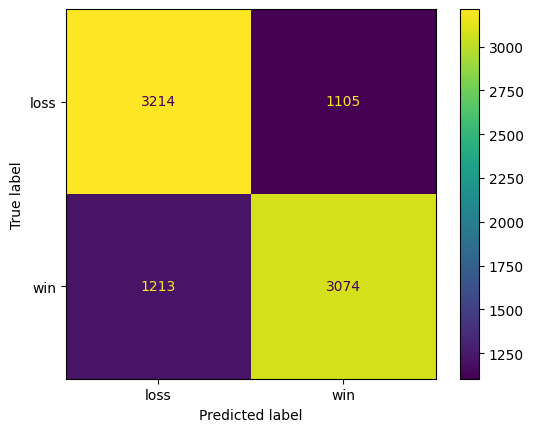

Accuracy: 0.7306530327678364
Average Decision Certainty: 0.685220870417245


In [ ]:
# generate evaluation metrics
evaluate(y_test, y_pred)
print("Average Decision Certainty:", np.average(confidence))

kNN --> Predefined kNN Library

In [ ]:
knn = KNeighborsClassifier(n_neighbors = H_k) # define classifier
knn.fit(X_train, y_train) # train classifier
y_pred = knn.predict(X_test) # Predict lables for the test dataset

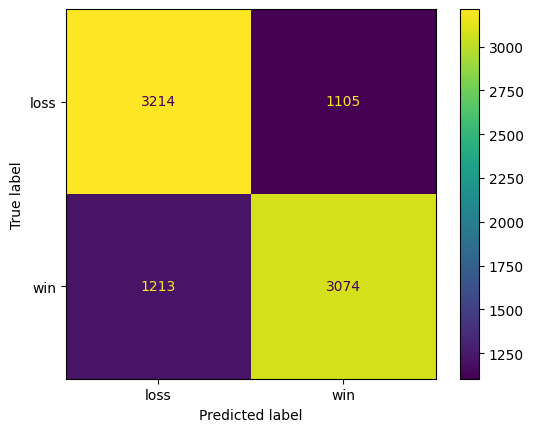

Accuracy: 0.7306530327678364


In [ ]:
# generate evaluation metrics
evaluate(y_test, y_pred)

Similar methodologies produce the same results for normal kNN --> acts as another evaluator to prove the self created kNN's efficacy

kNN --> Weighted kNN

In [ ]:
# function weighted k nearest neighbors
def W_kNN(point, dff, k):
  attributes = ['Wards', 'Wards_Destroyed', 'First_Blood', 'Kills', "Aces", 'Assists', 'Grubs', 'Cloud', 'Infernal', 'Mountain', 'Ocean', 'Chemtech', 'Hextech', 'Heralds', 'Towers_Destroyed', 'Turret_Plates', 'Inhibitors_Taken', 'Gold', 'Avg_Lvl', 'CS', 'Jungle_Monsters_Taken', 'Gold_Diff', 'XP_Diff', 'Damage', 'Side']

  # calculate the distance each training point object and the test point
  distances = list(dff[attributes].sub(point[attributes].to_numpy(), axis = 1).pow(2).sum(axis = 1).pow(.5))

  # create an index list to assign training point object value to its respective distance
  id = [i for i in range(0, len(distances))]

  # zip the ids and distances, sort by distances
  neighbors = zip(id, distances)
  neighbors = sorted(neighbors, key = lambda x: x[1])

  # collect the k nearest neighbors (k objects with the lowest distance from ref)
  candidates, weight = list(zip(*neighbors)) # instead of discarding distances (like in regular kNN), collect them to create weights
  candidates = np.array(candidates[:int(math.floor(k))])

  # store/calculate weights of each candidate (based on distance)
  weight = np.array(weight[:int(math.floor(k))]) + 1e-7 # add a small value 1e-7 to avoid division by 0 without significantly impacting results
  weight = 1 / np.square(weight) # use inverse distance as a weighting measure

  # collect the decisions of the k nearest neighbors
  win_loss = dff.iloc[candidates].Win.tolist()

  # calculate weighted vote
  win = np.dot(win_loss, weight) # get the dot product of the weights and win_loss votes
  loss = np.sum(weight) - win

  # majority vote with the nearest neighbor decisions
  # win value should be greater than loss value to vote win (& vice versa)
  return ('loss', loss/np.sum(weight)) if win < loss else ('win', win/np.sum(weight))

In [ ]:
# new function to test accuracy of k nearest neighbors
def format_WkNN(test_set, training_set):
  y_pred = [] # list to store decisions
  y_test = [] # list of ground truths
  certainties = [] # list of classification certainties

  #iterate through objects in the test set
  for i in range(0, len(test_set)):
    test = test_set.iloc[i] # extract test point information
    y_test.append(test.Win) # store gound truth
    decision, certainty = W_kNN(test, training_set, H_k)

    y_pred.append(1 if decision == 'win' else 0) # store the kNN decision
    certainties.append(certainty) # store decision certainty

  return y_pred, y_test, certainties # return accuracy metrics

In [ ]:
# get weighted kNN predictions for the testing data
y_pred, y_test, confidence = format_WkNN(testing_data, training_data)
# ~ 8,000 cacluations --> runtime ~ 19 minutes

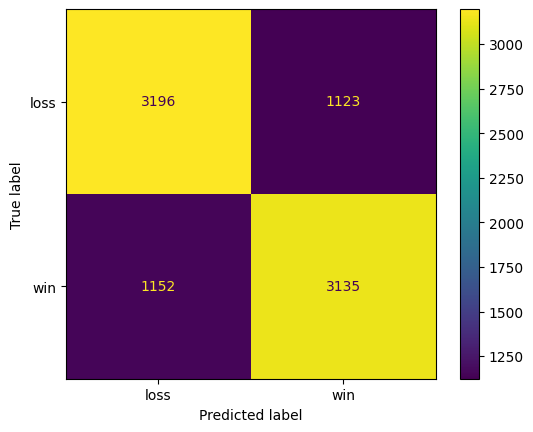

Accuracy: 0.7356495468277946
Average Decision Certainty: 0.6967824142424135


In [ ]:
# generate evaluation metrics
evaluate(y_test, y_pred)
print("Average Decision Certainty:", np.average(confidence))

W_kNN trades-off TP and FP to get better TN and FN rates compared to kNN

kNN --> Predefined Weighted kNN Library

In [ ]:
knn = KNeighborsClassifier(n_neighbors = H_k, weights = 'distance') # define classifier
knn.fit(X_train, y_train) # train classifier
y_pred = knn.predict(X_test) # Predict lables for the test dataset

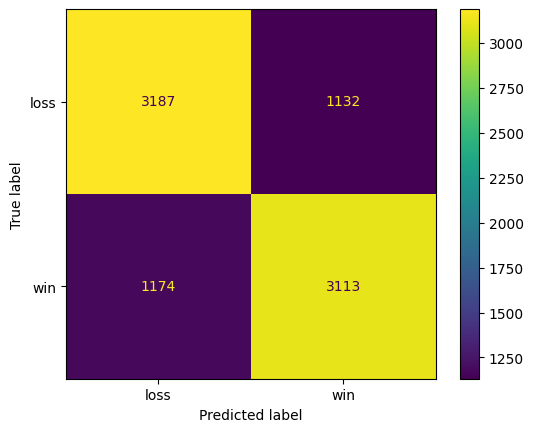

Accuracy: 0.7320474087845689


In [ ]:
# generate evaluation metrics
evaluate(y_test, y_pred)

Self created weighted kNN performs better (likely due to our function using inverse squared distance as weights and the library using inverse distance as weights)

Methodology --> Classification --> Decision Tree (DT)

DT --> Methodology Specific Preprocessing

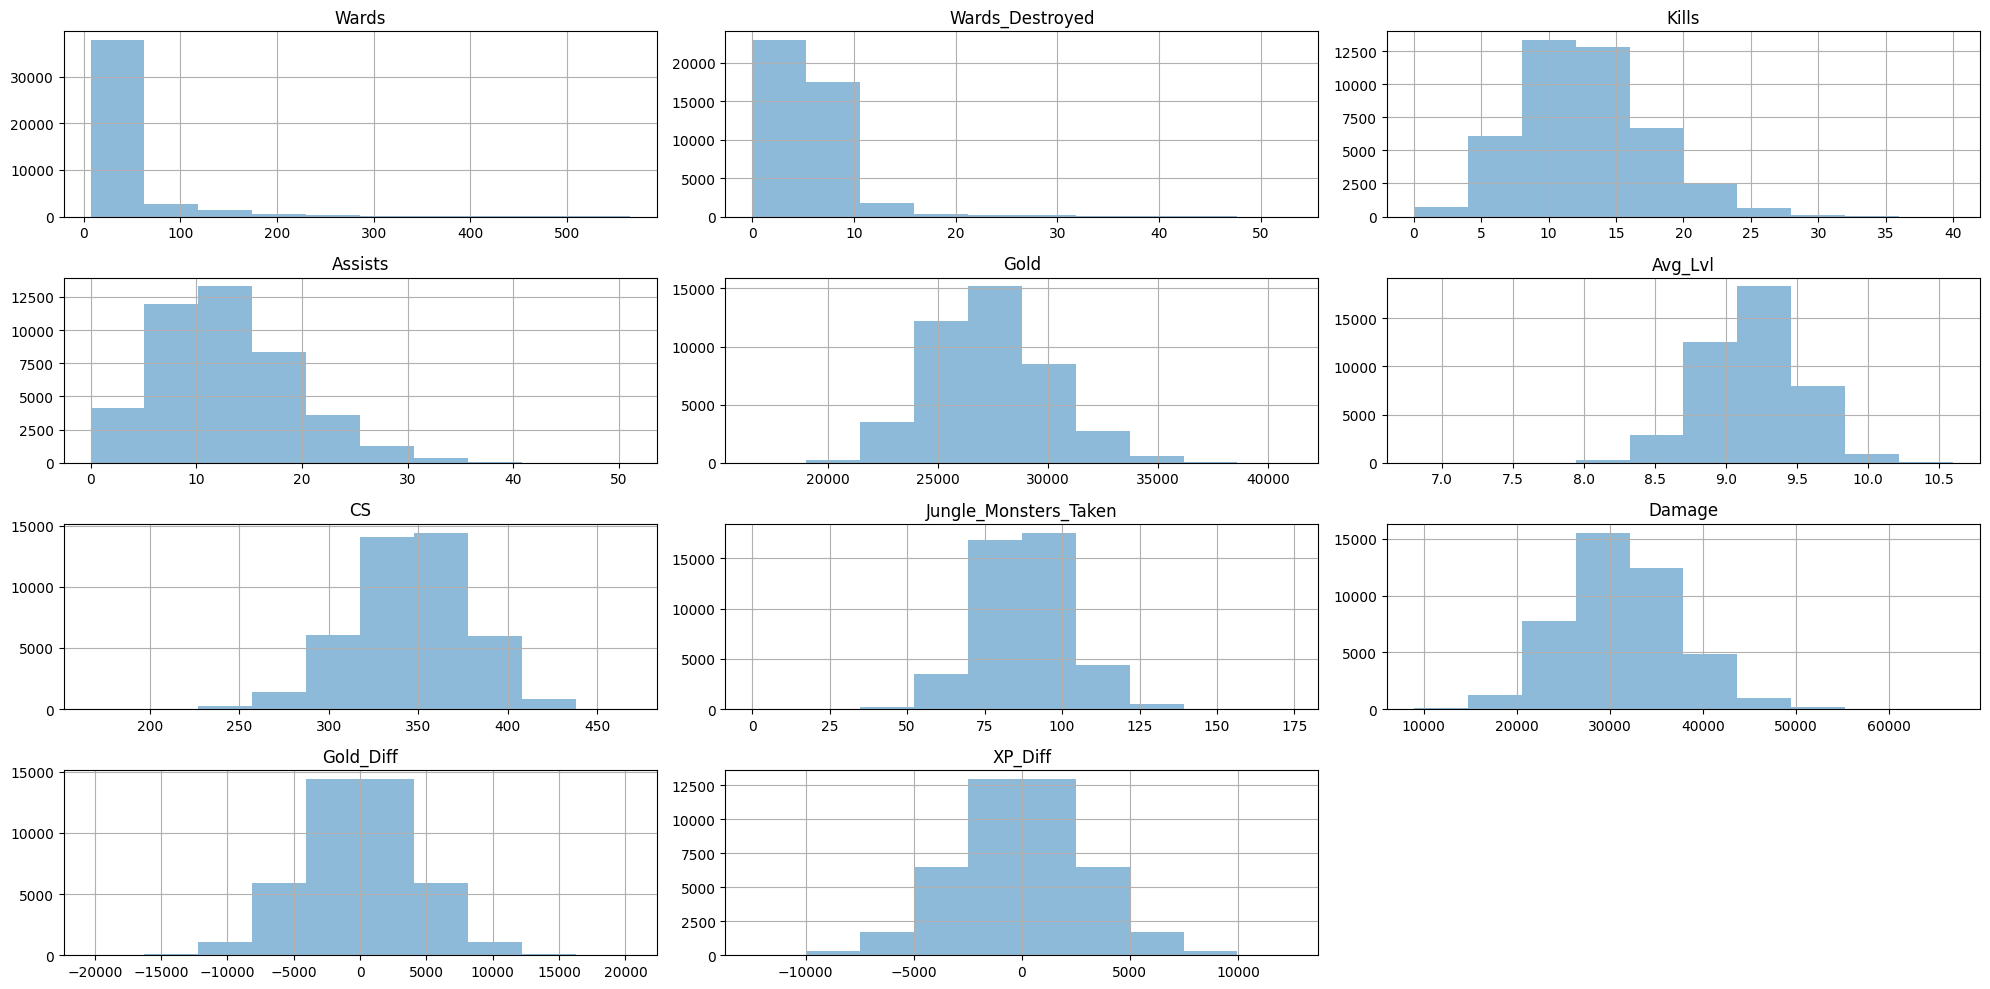

In [ ]:
df.hist(column = ['Wards', 'Wards_Destroyed', 'Kills', 'Assists', 'Gold', 'Avg_Lvl', 'CS', 'Jungle_Monsters_Taken', 'Damage', 'Gold_Diff', 'XP_Diff'], alpha = 0.5, figsize = (20, 10))
plt.tight_layout()
plt.show()

In [ ]:
# create Decision Tree copy of dataset
DT = df.copy(deep = True)

# discretize numeric values -> ['Wards', 'Wards_Destroyed', 'Kills', 'Assists', 'Gold', 'Avg_Lvl', 'CS', 'Jungle_Monsters_Taken', 'Gold_Diff', 'XP_Diff', 'Damage']
# width bin uniform numeric attributes
width_bin = ['Gold_Diff', 'XP_Diff', 'Jungle_Monsters_Taken']

for bin in width_bin:
  DT[bin] = pd.cut(DT[bin], bins = 10, precision= 0) # create bins using qcut
  DT[bin] = DT[bin].apply(lambda x: x.mid) # use the bin average as the object label

# frequency bin skewed numeric attributes
frequency_bin = ['Wards', 'Wards_Destroyed', 'Kills', 'Assists', 'Gold', 'Avg_Lvl', 'CS', 'Damage']

for bin in frequency_bin:
  DT[bin] = pd.qcut(DT[bin], q = 10, duplicates = 'drop', precision = 0) # create bins using qcut
  DT[bin] = DT[bin].apply(lambda x: x.mid) # use the bin average as the object label

# convert bins lables to numeric values
DT = DT.apply(pd.to_numeric)

Binning creates more consistent distributions and eliminates noisy values.

In [ ]:
# Create new training and testing sets
# independent variables
t = ['Wards', 'Wards_Destroyed', 'First_Blood', 'Kills', "Aces", 'Assists', 'Grubs', 'Cloud', 'Infernal', 'Mountain', 'Ocean', 'Chemtech', 'Hextech', 'Heralds', 'Towers_Destroyed', 'Turret_Plates', 'Inhibitors_Taken', 'Gold', 'Avg_Lvl', 'CS', 'Jungle_Monsters_Taken', 'Gold_Diff', 'XP_Diff', 'Damage', 'Side']
X = DT[t] # Features
y = DT.Win # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1) # 70% training and 30% test

DT --> Predefined Decision Tree Library

DT --> Predefined Decision Tree Library --> Base Line Classifier

In [ ]:
clf = DecisionTreeClassifier() # Create Decision Tree classifer object
clf = clf.fit(X_train,y_train) # Train Decision Tree Classifer
y_pred = clf.predict(X_test) # Predict the response for test dataset

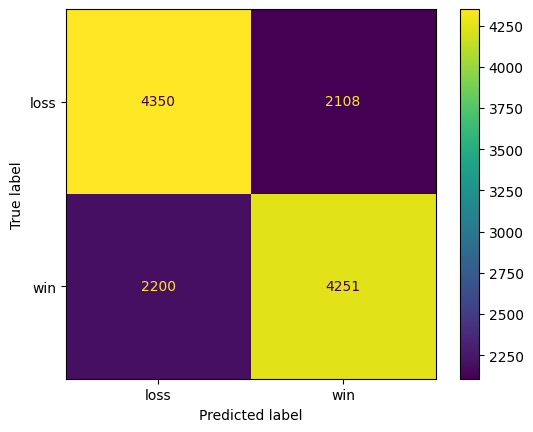

Accuracy: 0.666279339995352


In [ ]:
# generate evaluation metrics
evaluate(y_test, y_pred)

DT --> Tree Pruning --> Depth Based

In [ ]:
# prune based on stopping criteria --> depth based
observations = []

# iterate through possible depth candidates
for depth in range(1, 100):
  # retrain with new depth constraint
  clf = DecisionTreeClassifier(max_depth = depth)
  clf = clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)

  # store the model accuracies for plotting
  observations.append(metrics.accuracy_score(y_test, y_pred))

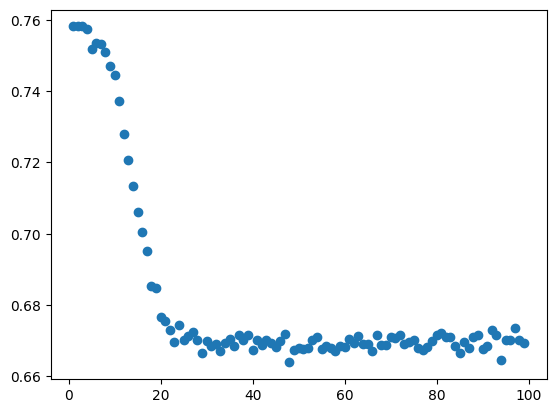

In [ ]:
# plot the depth/accuracy values to choose a max depth
plt.scatter([i for i in range(1, 100)], observations)
plt.show()

Based on the graph, choose a stopping depth of 5 (reduce overfitting)

In [ ]:
# based on graph, choose a max depth of 5
# define the new tree of depth 5
clf = DecisionTreeClassifier(max_depth = 5)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

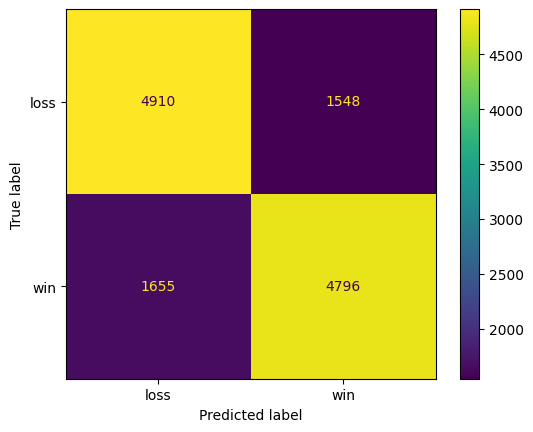

Accuracy: 0.7518785343558757


In [ ]:
# generate evaluation metrics
evaluate(y_test, y_pred)

Substantial increase in accuracy compared to the baseline (shows the full tree with no stopping conditions overfits the data)

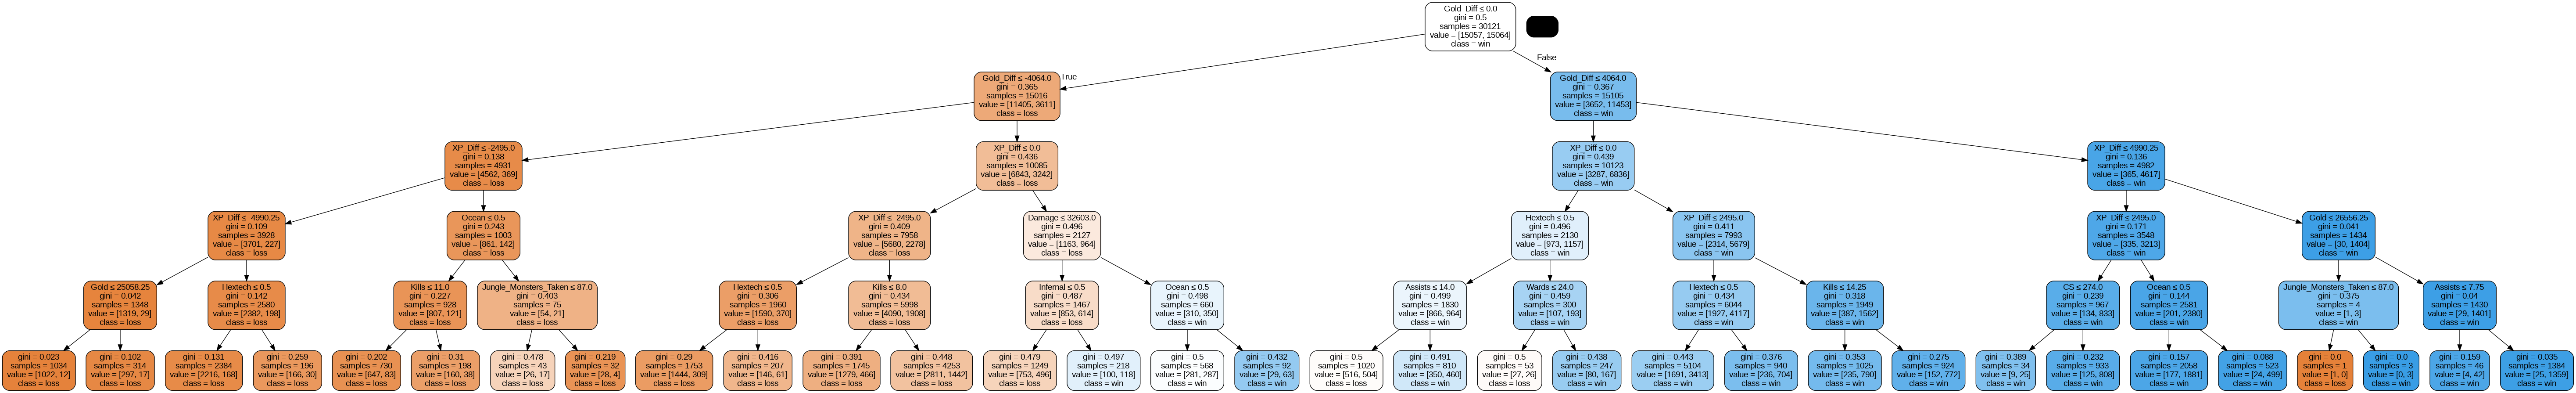

In [ ]:
# Visualize the new tree
dot_data = StringIO()
export_graphviz(clf, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = t,class_names = ['loss','win'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# write and save tree
graph.write_png('depth_determined_tree.png')
Image(graph.create_png())

DT --> Tree Pruning --> Heuristic Approach

In [ ]:
# heuristically eliminate the worst attribute to create a smaller tree
HTree = DecisionTreeClassifier(max_depth = 5) # create a decision tree

# set of candidates
candidates = {'Wards', 'Wards_Destroyed', 'First_Blood', 'Kills', "Aces", 'Assists', 'Grubs', 'Cloud', 'Infernal', 'Mountain', 'Ocean', 'Chemtech', 'Hextech', 'Heralds', 'Towers_Destroyed', 'Turret_Plates', 'Inhibitors_Taken', 'Gold', 'Avg_Lvl', 'CS', 'Jungle_Monsters_Taken', 'Gold_Diff', 'XP_Diff', 'Damage', 'Side'}
rejected = set() # ordered set of rejected attributes

# remove candidates until accuracy falls below 70% (condition set later) or 5 candidates remain
while (len(rejected) < 20):
  # store the best attribute to remove
  # the attribute that when removed, results in the highest accuracy among other candidates
  best = ['none', 0]

  # iterate through attributes
  for attribute in candidates - rejected:
    # test accuracy without the test attribute
    rejected.add(attribute)

    # train tree on candidate subset (candidates - rejected)
    HTree = HTree.fit(X_train[list(candidates - rejected)], y_train)

    y_pred = HTree.predict(X_test[list(candidates - rejected)]) # predict with the new model
    temp = metrics.accuracy_score(y_test, y_pred) # get new model accuracy

    # determine if a higher accuracy model emerges
    if temp > best[1]:
      best = [attribute, temp] # reasign the best removal

    rejected.remove(attribute) # remove the attribute from rejected for next candidate test

  # if the new model is less than 70% accurate, leave the loop early
  if (best[1] < 0.7): break
  else: rejected.add(best[0]) # permanenlty add the removed attribute to the rejected list

trimmed_attributes = list(candidates - rejected)
print("Trimmed Attributes:", trimmed_attributes)

Trimmed Attributes: ['Gold_Diff', 'Hextech', 'Towers_Destroyed', 'Kills', 'Chemtech']


The above attributes should be the most important metrics in deciding game outcome.

In [ ]:
# based on the heuristic results, create a new tree
HTree = HTree.fit(X_train[trimmed_attributes], y_train)
y_pred = HTree.predict(X_test[trimmed_attributes])

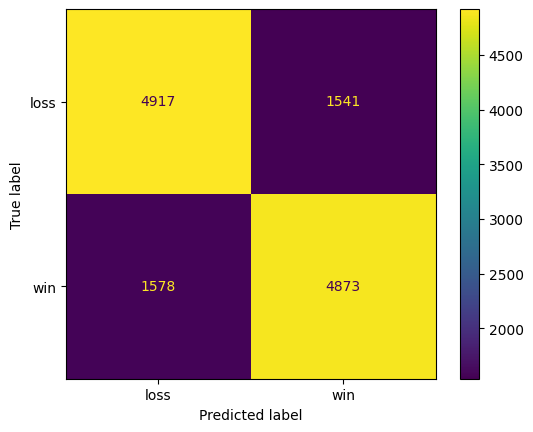

Accuracy: 0.7583856224339608


In [ ]:
# generate evaluation metrics
evaluate(y_test, y_pred)

Slight accuracy increase using heuristics

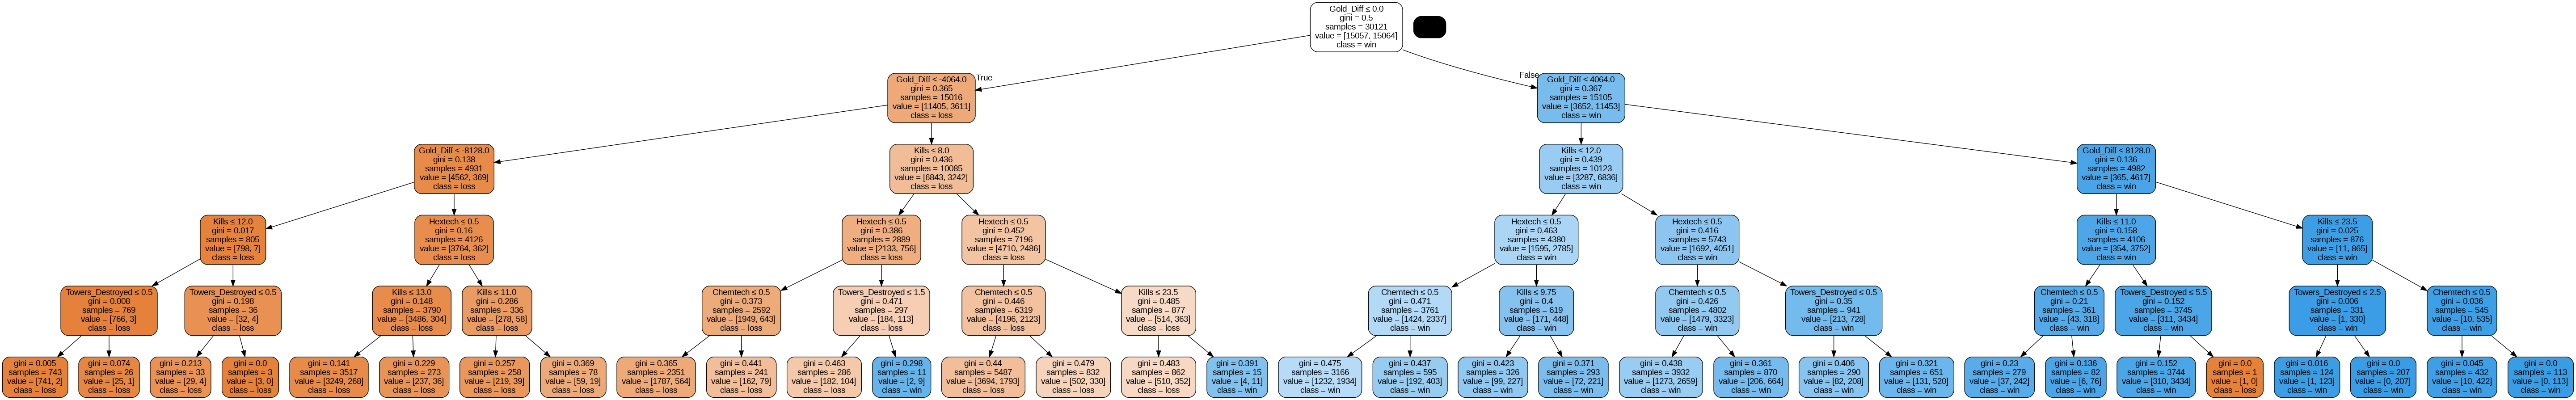

In [ ]:
# Visualize the new tree
dot_data = StringIO()
export_graphviz(HTree, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = trimmed_attributes, class_names = ['loss','win'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# write and save tree
graph.write_png('heuristically_pruned_tree.png')
Image(graph.create_png())

Evaluation:

<p>
Notably, while "win" is listed as the class label, the designed classifiers don't operate under the assumption of asymmetric binary attributes. The project aims to create a good classifier that can predict wins or losses to provide reasonable guidance in forfeiture. Likewise, wins and losses are weighted equally as symmetric binary attributes.

<p>
To this end, standard supervised classification metrics were chosen to evaluate each model's performance. Holdout (80% testing, 20% training for lazy learning - 70% testing, 30% training for eager learning) and ground truth labels were used to create confusion matrices. The matrices were then visualized to compare the positive and negative class frequencies to find imbalances. Since the classes were reasonably balanced, accuracy was chosen as the primary numerical evaluator for the tested models.

<p>
An arbitrary 70% accuracy threshold was chosen for evaluation. While actual metrics may vary between model executions (due to varied testing and training set generation), the only model that generated an accuracy below 70% was the baseline (untrimmed) decision tree (likely due to overfitting). From this point onwards, the classifiers had above 70% accuracy and performed incrementally better in the order of kNN, weighted kNN, depth-constrained decision trees, and heuristically pruned trees. Despite this hierarchy, the variance between the model acceptable model accuracies was minimal (about ± 2.5%).

<p>
We were also able to use predefined libraries, which we know work correctly, to further evaluate our kNN implementations. Our standard kNN produced the same results as the predefined library, proving our implementation methodology worked correctly. Moreover, our weighted kNN function outperformed the predefined kNN implementation (due to stronger weighting mechanics).

Discussion:

<p>
Findings: These different models produced interesting findings. For instance, the average certainty/confidence for both kNN models (weighted and unweighted) revealed that the distance between wins and losses wasn't very large. The fact that an object's nearest neighbors include both wins and losses proves that a winning game state can quickly devolve into a losing state (and vice versa). Providing players with their likely game outcome and the confidence of that decision might be more helpful in guiding their decision to surrender. If a player is given a loss prediction with low confidence, they might want to continue playing the game in hopes of a comeback. Beyond kNN, the decision trees provide finer-grained metrics regarding game states based on attributes. Although specific nodes can change based on testing set generation, most trees chose "Gold Difference" as their first split node. This is consistent with expectations since gold leads in LoL should cause considerable disparities between team strengths. As a result, other gold-based metrics such as "Total Gold" and "Jungle Monsters Taken" also tend to appear in the tree's nodes. After gold-based attributes, objective-based attributes like dragons and towers started predicting outcomes. Likewise, these factors become critical metrics to judge game states and whether a forfeiture should occur.


<p>
Insights: These findings provide valuable insights into LoL games and how they should be played. A heavy emphasis on gold indicates that getting gold should be the highest priority for most players. The imbalance created by gold differences is the most reliable way to win games consistently. As such, if a significant gold difference exists 15 minutes into the game's progression, choosing to forfeit might be a good option. After establishing a gold lead, teams should leverage their advantage to secure objectives around the map. This helps to snowball a gold lead further and deny opponents' resources. Likewise, if the opponents have a gold lead and multiple objects, the case for surrendering grows even stronger. The general attributes prioritized by the decision trees align with and support current successful gameplay strategies. While these classifiers might provide good cases for early forfeiture, the lazy learning metrics offer a robust counter stance that supports playing a game out to completion. Generally uncertain kNN decisions prove that lost games can usually be won. Moreover, the best classifier only produces an accuracy rate of ~ 76%. In this sense, a player could take the optimistic stance that bad games at 15 minutes can still be won with upwards of ~ 20% odds. Inevitably, the final decision resides with the specific player and their perception.

Limitations: By design, the trained models feature limitations. The training set consists of only North American, Diamond Tier ranked games. This means the generated classifiers should have lower accuracy with LoL games outside these narrow classification conditions (different regions and ranks). This is problematic considering North American, Diamond Tier ranked games only make up a small fraction of total LoL games played. Moreover, strategies and gameplay patterns in LoL are constantly evolving. A classifier trained on current statistics quickly loses relevance within the upcoming months. In other words, the classifiers have limited scope and timeliness.

Feedback: Personal feedback loops were utilized throughout the project to increase model(s) accuracy and insight. Initially, we created our kNN model; however, it was ill-optimized and took a long time to make decisions. Internal feedback progressively refined the model and brought it to an acceptable point. From here, we decided to add different variations to try and increase our model's accuracy, so we introduced a weighting element to the neighbors based on distance. This new element slightly increased accuracy. At this point, we only had lazy learning in our projects, so we incorporated decision trees to represent eager learning methodologies. From here, we progressively refined the tree structure to increase its accuracy. These developments and refinements only occurred because of our internal feedback mechanisms. Some future feedback we would give ourselves is to increase the scope of games analyzed. Many more ranked tiers and games could be analyzed to increase our classifiers' usefulness. We could also try using ensemble methods like combining the votes from our kNN and decision tree classifiers to get better results. We would consider these starting points to iterate our project further.